2023.05.15 박진윤 선임연구원, 태안군 인공지능유합산업진흥원

## Library import

In [24]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import pickle
import random
import matplotlib.pyplot as plt

from Quaternion import *

## Load data

In [2]:
# pickle dir
outdir_pickle = './pickle'
fn_pickle_pub = '{}/0531_elderly_youtube_class4_len_all_pub.pickle'.format(outdir_pickle)

In [3]:
# change all the necessary information for the according dataset
dataset_name = fn_pickle_pub.split('/')[-1].split('_')[1]
print(f'This notebook is working on {dataset_name} dataset')

if dataset_name == 'UTK':
    spine_joint_index = 1 
    num_joints = 20
    nbsample_crop = 70 
    right_hip_joint_index = 16
    left_hip_joint_index = 12
    mid_hip_joint_index = 0
    neck_joint_index = 2
elif dataset_name == 'FLO':
    spine_joint_index = 2 
    num_joints = 15
    nbsample_crop = 35 
    right_hip_joint_index = 12
    left_hip_joint_index = 9
    mid_hip_joint_index = 2
    neck_joint_index = 1
elif dataset_name == 'MSRA':
    spine_joint_index = 1
    num_joints = 20
    nbsample_crop = 70 
    right_hip_joint_index = 4
    left_hip_joint_index = 5
    mid_hip_joint_index = 6
    neck_joint_index = 2
else:
    spine_joint_index = 7 
    num_joints = 17
    nbsample_crop = 100 
    right_hip_joint_index = 1
    left_hip_joint_index = 4
    mid_hip_joint_index = 0
    neck_joint_index = 8

seq_length = nbsample_crop
pad_value = 0

This notebook is working on elderly dataset


Load pickle data

In [9]:
if os.path.exists(fn_pickle_pub):
    print('{} exists....OK'.format(fn_pickle_pub))

    print('load from pickle files')
    file = open(fn_pickle_pub, 'rb')
    data = pickle.load(file)
    file.close()

    dataset = data[0]
    labels = data[1]  
    class_name_pub = data[2]  
    dname = data[3] 
    tstring = data[4]

./pickle/0531_elderly_youtube_class4_len_all_pub.pickle exists....OK
load from pickle files


In [10]:
print(f'Number of samples: {np.shape(dataset)[0]}')
print(f'Shape of dataset: {np.shape(dataset)}')

Number of samples: 1265
Shape of dataset: (1265, 60, 51)


### Padding
- 각 segment 데이터를 동일한 길이로 설정하기 위해 '0'값으로 패딩처리
    - MSRA, FLO, UTK 데이터셋들만 패딩 작업 적용

In [11]:
class MyPaddingSeq3d():
    def __init__(self, maxlen=None, pad_value=0.0):
        super(MyPaddingSeq3d, self).__init__()
        self.maxlen  = maxlen 
        self.pad_value = pad_value
    
    def ddd(self, sequences):
        sequences_out = []
        
        seq_num = len(sequences)
        print(seq_num)
        for i in range(seq_num):
            seq_1 = sequences[i]
            seq_1 = list(seq_1)
            #print(len(seq_1))
            dim = np.shape(seq_1[-1])[0]
            if len(seq_1) < self.maxlen:
                p = np.full((self.maxlen - len(seq_1), dim), self.pad_value)
                s = np.vstack((seq_1, p))
                sequences_out.append(s)
                
            elif len(seq_1) >= self.maxlen:
                x = seq_1[:self.maxlen]
                sequences_out.append(x)
            
        return np.array(sequences_out)

In [12]:
pad = MyPaddingSeq3d(maxlen = nbsample_crop, pad_value = pad_value)

In [13]:
if dataset_name in['MSRA', 'FLO', 'UTK']:
    padded_data = pad.ddd(dataset)
    print('padded')
else:
    padded_data = dataset.copy()
    print('not padded')

not padded


## Preprocessing and augmentation layers

##### combination of layers
- preprocess: scale norm and translation removal
- test_rotation: scale norm + trans removal + single rotation
- augmentation_layer: scale + trans + augmentation(rotation)
- axis_normalize_layer: scale + trans + yaxis_rotation

In [14]:
def preprocess(inputdata, inputlabels):

    normalization_layer = SkeletonNormalizationLayer(joints=num_joints)
    translation_layer = SpineJointTranslationLayer(joints=num_joints, spine_joint_index=mid_hip_joint_index)
    processed_sequences = []
    for seq in inputdata:
        
        translate_sequences = translation_layer.translate_sequence(seq)
        normalize_sequences = normalization_layer.nomalize_sequence(translate_sequences)
        processed_sequences.append(normalize_sequences)
        
    data = np.array(processed_sequences)  # Use the augmented_sequences as input to the model
    label = inputlabels
    
    return data, label

In [15]:
def test_rotation(inputdata, inputlabels):

    normalization_layer = SkeletonNormalizationLayer(joints=num_joints)
    translation_layer = SpineJointTranslationLayer(joints=num_joints, spine_joint_index=mid_hip_joint_index)

    rotated_sequences = []
    for seq in inputdata:
        angle_list = [random.randint(0,20)]
        augmentation_layer = SkeletonAugmentationLayer(joints=num_joints, angle_list=angle_list)
        
        translate_sequences = translation_layer.translate_sequence(seq)
        normalize_sequences = normalization_layer.nomalize_sequence(translate_sequences)
        rotated_sequences.extend(augmentation_layer.augment_sequence(normalize_sequences))
    

    data = np.array(rotated_sequences)  # Use the augmented_sequences as input to the model
    label = np.array(inputlabels)
    
    return data, label

In [16]:
def test_rotation_spine(inputdata, inputlabels):

    normalization_layer = SkeletonNormalizationLayer(joints=num_joints)
    translation_layer = SpineJointTranslationLayer(joints=num_joints, spine_joint_index=mid_hip_joint_index)

    rotated_sequences = []
    for seq in inputdata:
        angle_list = [random.randint(0,20)]
        spine_rotation_layer = SkeletonRotationLayer(mid_hip_idx=mid_hip_joint_index, 
                                             neck_idx=neck_joint_index, 
                                             num_joints=num_joints, angle_list=angle_list)
        
        translate_sequences = translation_layer.translate_sequence(seq)
        normalize_sequences = normalization_layer.nomalize_sequence(translate_sequences)
        rotated_sequences.extend(spine_rotation_layer.spine_augment_sequence(normalize_sequences))
    

    data = np.array(rotated_sequences)  # Use the augmented_sequences as input to the model
    label = np.array(inputlabels)
    
    return data, label

In [17]:
def axis_normalize_layer(inputdata, inputlabels):
    
    normalization_layer = SkeletonNormalizationLayer(joints=num_joints)
    translation_layer = SpineJointTranslationLayer(joints=num_joints, spine_joint_index=mid_hip_joint_index)
    yaxis_rotation_layer = SkeletonFacingYAxisLayer(joints=num_joints, 
                                                left_hip_joint_index=left_hip_joint_index, 
                                                right_hip_joint_index=right_hip_joint_index)

    yaxis_rotated_sequences = []
    
    for seq in inputdata:
        translate_sequences = translation_layer.translate_sequence(seq)
        normalize_sequences = normalization_layer.nomalize_sequence(translate_sequences)
        yaxis_rotate_sequences = yaxis_rotation_layer.yaxis_rotate_sequence(normalize_sequences)
        yaxis_rotated_sequences.append(yaxis_rotate_sequences)
        
    data = np.array(yaxis_rotated_sequences)  # Use the augmented_sequences as input to the model
    label = np.array(inputlabels)
    
    return data, label

In [18]:
def augmentation(inputdata, inputlabels, N):
    random.seed(1214)
    angle_list = [random.randint(0, 20) for x in range(N)]

    normalization_layer = SkeletonNormalizationLayer(joints=num_joints)
    translation_layer = SpineJointTranslationLayer(joints=num_joints, spine_joint_index=mid_hip_joint_index)
    augmentation_layer = SkeletonAugmentationLayer(joints=num_joints, angle_list=angle_list)
    
    augmented_sequences = []
    for seq in inputdata:
        
        translate_sequences = translation_layer.translate_sequence(seq)
        normalize_sequences = normalization_layer.nomalize_sequence(translate_sequences)
        augmented_sequences.extend(augmentation_layer.augment_sequence(normalize_sequences))

    augmented_y = []
    for y in inputlabels:
        for _ in range(N):
            augmented_y.append(y)

    X_train = np.array(augmented_sequences)  # Use the augmented_sequences as input to the model
    y_train = np.array(augmented_y)

    return X_train, y_train

In [19]:
def augmentation_spine(inputdata, inputlabels, N):
    random.seed(1214)
    angle_list = [random.randint(0, 20) for x in range(N)]

    normalization_layer = SkeletonNormalizationLayer(joints=num_joints)
    translation_layer = SpineJointTranslationLayer(joints=num_joints, spine_joint_index=mid_hip_joint_index)
    spine_rotation_layer = SkeletonRotationLayer(mid_hip_idx=mid_hip_joint_index, 
                                                 neck_idx=neck_joint_index, 
                                                 num_joints=num_joints, angle_list=angle_list)


    augmented_sequences = []
    for seq in inputdata:
        
        translate_sequences = translation_layer.translate_sequence(seq)
        normalize_sequences = normalization_layer.nomalize_sequence(translate_sequences)
        augmented_sequences.extend(spine_rotation_layer.spine_augment_sequence(normalize_sequences))

    augmented_y = []
    for y in inputlabels:
        for _ in range(N):
            augmented_y.append(y)

    X_train = np.array(augmented_sequences)  # Use the augmented_sequences as input to the model
    y_train = np.array(augmented_y)

    return X_train, y_train

## Visualization

In [20]:
if dataset_name == 'FLO':
    bones_3d = [[0, 1, 2],[1, 2, 2],[1, 3, 1],[3, 4, 1],[4, 5, 1],[1, 6, 0],[6, 7, 0],[7, 8, 0],[2, 9, 1],[9, 10, 1],[10, 11, 1],[2, 12, 0],[12, 13, 0],[13, 14, 0]] #0 == red/right, 1 == blue/left, 2 == black/mid
elif dataset_name == 'MSRA':
    bones_3d = [[19, 2, 2],[2, 3, 2],[3, 6, 2],[2, 1, 0],[1, 8, 0],[8, 10, 0],[10, 12, 0],[2, 0, 1],[0, 7, 1],[7, 9, 1],[9, 11, 1],[6, 5, 0],[5, 14, 0],[14, 16, 0],[16, 18, 0],[6, 4, 1],[4, 13, 1],[13, 15, 1],[15, 17, 1]] #0 == red/right, 1 == blue/left 2 == black/mid
elif dataset_name == 'UTK':
    bones_3d = [[3, 2, 2],[2, 1, 2],[1, 0, 2],[2, 4, 1],[4, 5, 1],[5, 6, 1],[6, 7, 1],[2, 8, 0],[8, 9, 0],[9, 10, 0],[10, 11, 0],[0, 12, 1],[12, 13, 1],[13, 14, 1],[14, 15, 1],[0, 16, 0],[16, 17, 0],[17, 18, 0],[18, 19, 0]] #0 == red/right, 1 == blue/left 2 == black/mid
else:
    bones_3d = [[0,1],[1,2],[2,3],[0,4],[4,5],[5,6],[0,7],[7,8],[8,9],[9,10],[8,11],[11,12],[12,13],[8,14],[14,15],[15,16]]

In [26]:
## testing
normalization_layer = SkeletonNormalizationLayer(joints=num_joints)
translation_layer = SpineJointTranslationLayer(joints=num_joints, spine_joint_index=spine_joint_index)

translated_sequences =[]
normalized_sequences =[]
augmented_sequences = []
for seq in tqdm(padded_data):

    normalize_sequences = normalization_layer.nomalize_sequence(seq)
    normalized_sequences.append(normalize_sequences)
    translate_sequences = translation_layer.translate_sequence(normalize_sequences)
    translated_sequences.append(translate_sequences)
    
    angle_list = [random.randint(1,19) +0.5]
    augmentation_layer = SkeletonAugmentationLayer(joints=num_joints, angle_list=angle_list)
    augmented_sequences.extend(augmentation_layer.augment_sequence(translate_sequences))

label = labels
translated_sequences = np.array(translated_sequences)
normalized_sequences = np.array(normalized_sequences)
augmented_sequences = np.array(augmented_sequences)

translated_sequences.shape, normalized_sequences.shape, augmented_sequences.shape

100%|██████████| 1265/1265 [00:02<00:00, 503.17it/s]


((1265, 60, 51), (1265, 60, 51), (1265, 60, 51))

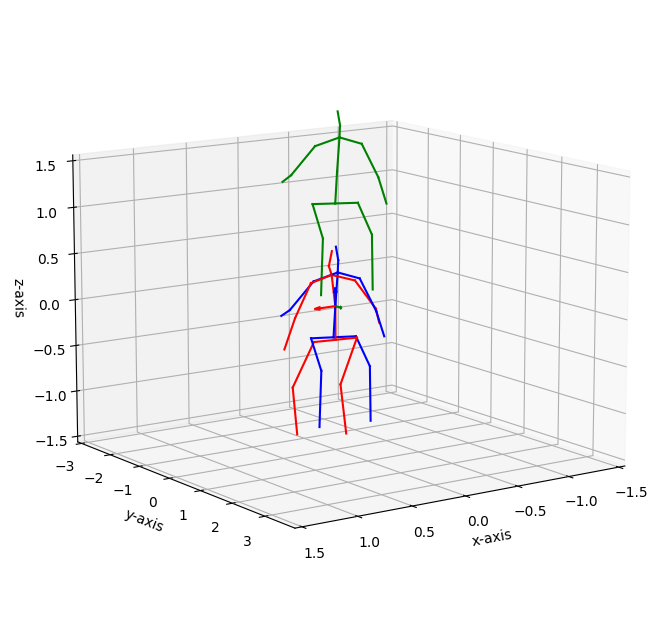

In [30]:
## visualize
## drawing multiple skeleton figures in one graph
s = 20 #sample idx
f = 21 # frame idx

plt.ioff()
fig = plt.figure(figsize=(8,8))

elev= 12
azim = 55
a = 1.5

ax = fig.add_subplot(projection='3d')
ax.view_init(elev,azim) #(elev = 위아래, azim = 좌우)
ax.set_xlim3d([-1*a, 1*a])
ax.set_ylim3d([-2*a, 2.5*a])
ax.set_zlim3d([-1*a, 1*a])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')

ax.quiver(0,0,0,0.2,0,0, color='r') #x-axis , label = 'x'
ax.quiver(0,0,0,0,0.2,0, color='g') #y-axis , label = 'y'
ax.quiver(0,0,0,0,0,0.2, color='b') #z-axis , label = 'z'

for bone in bones_3d:
    start = bone[0]
    end = bone[1]

    x = [(augmented_sequences[s][f][start*3]), (augmented_sequences[s][f][end*3])]
    y = [(augmented_sequences[s][f][start*3+1]), (augmented_sequences[s][f][end*3+1])]
    z = [(augmented_sequences[s][f][start*3+2]), (augmented_sequences[s][f][end*3+2])]

    ax.plot(x, y, z, c = 'r')

    x = [(normalized_sequences[s][f][start*3]), (normalized_sequences[s][f][end*3])]
    y = [(normalized_sequences[s][f][start*3+1]), (normalized_sequences[s][f][end*3+1])]
    z = [(normalized_sequences[s][f][start*3+2]), (normalized_sequences[s][f][end*3+2])]

    ax.plot(x, y, z, c = 'g')

    x = [(translated_sequences[s][f][start*3]), (translated_sequences[s][f][end*3])]
    y = [(translated_sequences[s][f][start*3+1]), (translated_sequences[s][f][end*3+1])]
    z = [(translated_sequences[s][f][start*3+2]), (translated_sequences[s][f][end*3+2])]

    ax.plot(x, y, z, c = 'b')

plt.show()